# Intestinal organoid differentiation - Data preprocessing

Preprocessing of scEU-seq organoid data by
* Excluding control cells identified via labeling time `"dmso"`
* Removing genes with less than 50 counts
* Normalizing counts
* Extracting 2000 highly variable features
* Log1p transforming total counts stored in `adata.X`
* Computing PCA
* Constructing a nearest neighbor graph with 30 neighbors and 30 principal components
* Computing UMAP embedding

## Library imports

In [1]:
import os
import sys

import pandas as pd

import matplotlib.pyplot as plt

import scanpy as sc
import scvelo as scv

from cr2 import running_in_notebook

sys.path.extend(["../../", "."])
from paths import DATA_DIR, FIG_DIR  # isort: skip  # noqa: E402

Global seed set to 0


## General settings

In [2]:
sc.settings.verbosity = 3
scv.settings.verbosity = 3

In [3]:
scv.settings.set_figure_params("scvelo")

In [4]:
SAVE_FIGURES = True

if SAVE_FIGURES:
    os.makedirs(FIG_DIR / "labeling_kernel", exist_ok=True)

## Data loading

In [5]:
adata = sc.read(DATA_DIR / "sceu_organoid" / "processed" / "raw.h5ad")

adata = adata[adata.obs["labeling_time"] != "dmso", :].copy()
adata.obs["labeling_time"] = adata.obs["labeling_time"].astype(float) / 60

adata.obs.drop(["well_id", "batch_id", "log10_gfp", "monocle_branch_id", "monocle_pseudotime"], axis=1, inplace=True)

del (
    adata.layers["labeled_unspliced"],
    adata.layers["labeled_spliced"],
    adata.layers["unlabeled_unspliced"],
    adata.layers["unlabeled_spliced"],
)

adata

AnnData object with n_obs × n_vars = 3500 × 9157
    obs: 'experiment', 'labeling_time', 'cell_type', 'som_cluster_id'
    var: 'ensum_id'
    uns: 'cell_type_colors'
    obsm: 'X_umap_paper'
    layers: 'labeled', 'total', 'unlabeled'

In [6]:
pd.DataFrame(adata.obs[["labeling_time", "experiment"]].groupby("experiment").apply(lambda x: x.value_counts())).rename(
    {0: "value_counts"}, axis=1
).droplevel(level=2).sort_index()

value_counts
experiment labeling_time              
Chase      0.00                    660
           0.75                    821
           6.00                    646
Pulse      2.00                   1373

In [7]:
adata.obs["cell_type_merged"] = adata.obs["cell_type"].copy()
adata.obs["cell_type_merged"].replace({"Enteroendocrine cells": "Enteroendocrine progenitors"}, inplace=True)

## Data preprocessing

In [8]:
scv.pp.filter_and_normalize(
    adata, min_counts=50, layers_normalize=["X", "labeled", "unlabeled", "total"], n_top_genes=2000
)
adata

Normalized count data: X, labeled, unlabeled, total.
Extracted 2000 highly variable genes.
Logarithmized X.


AnnData object with n_obs × n_vars = 3500 × 2000
    obs: 'experiment', 'labeling_time', 'cell_type', 'som_cluster_id', 'cell_type_merged', 'initial_size', 'n_counts'
    var: 'ensum_id', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'cell_type_colors'
    obsm: 'X_umap_paper'
    layers: 'labeled', 'total', 'unlabeled'

In [9]:
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


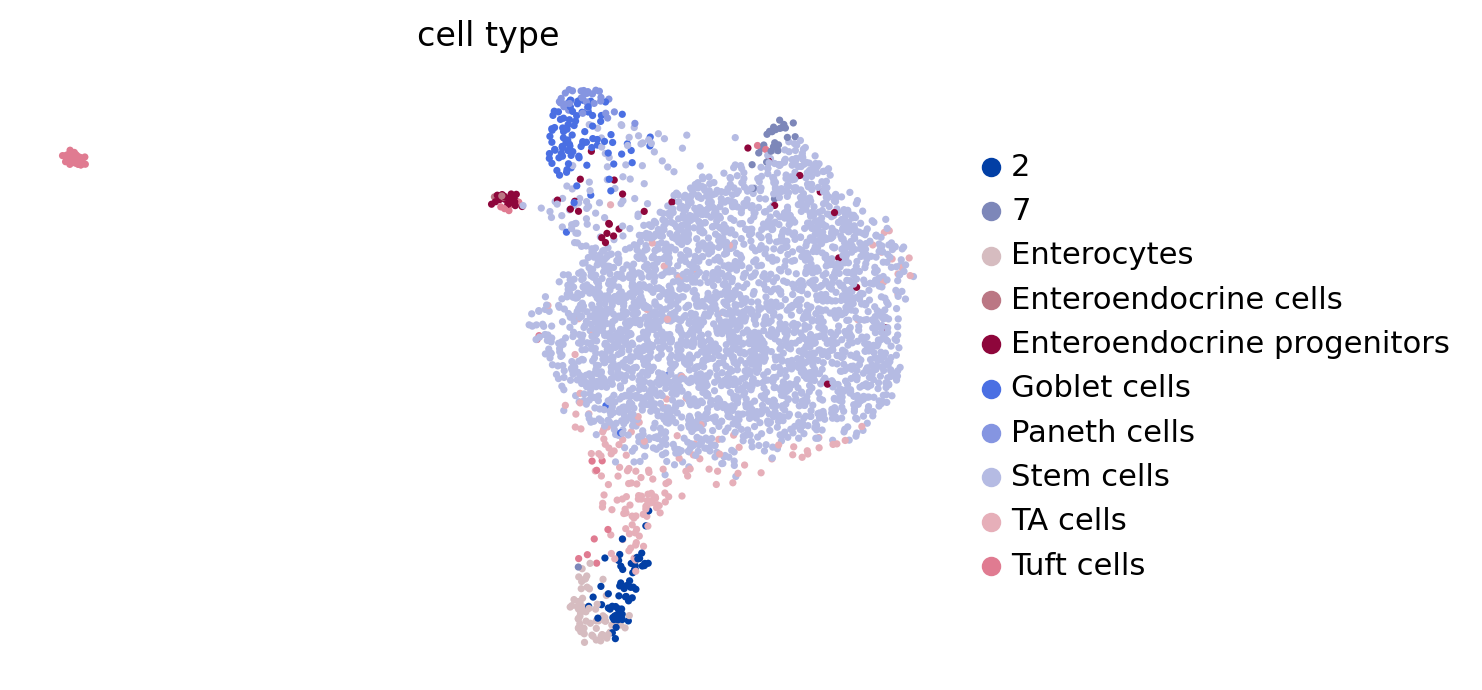

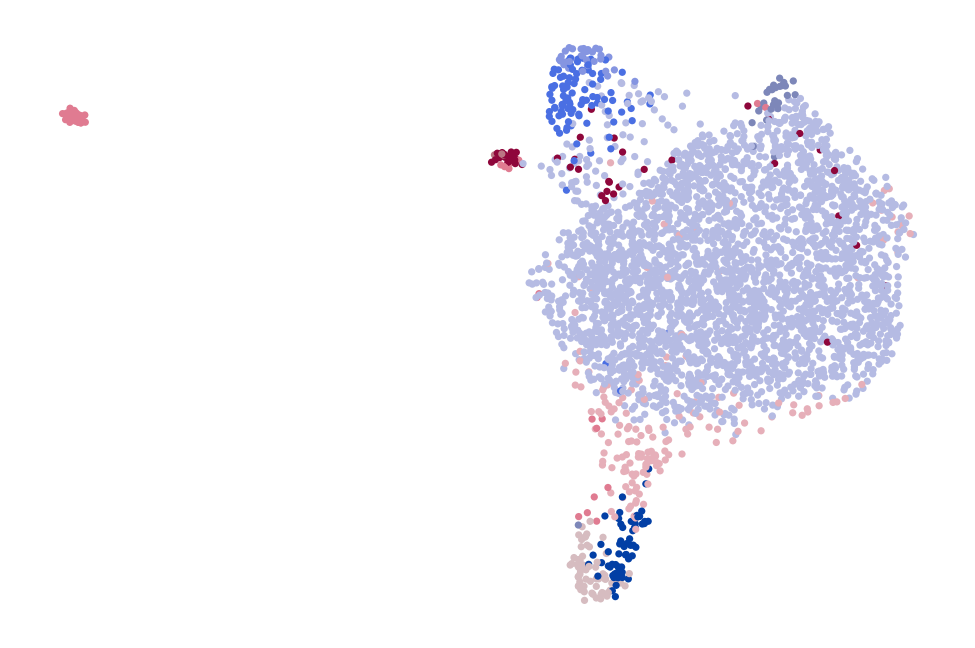

In [10]:
sc.tl.umap(adata)
if running_in_notebook():
    scv.pl.scatter(adata, basis="umap", color="cell_type", legend_loc="right")

if SAVE_FIGURES:
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.pl.scatter(adata, basis="umap", color="cell_type", title="", legend_loc=False, show=False, ax=ax)

    fig.savefig(
        FIG_DIR / "labeling_kernel" / "umap_colored_by_cell_type_full_data.eps",
        format="eps",
        transparent=True,
        bbox_inches="tight",
    )